In [2]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

# Hands-on Activity 23.4: Expected Improvement

## Objectives

+ Develop intuition about the expected improvement

## Expected Improvement
Let's reintroduce the same running example as the previous hands-on activity.

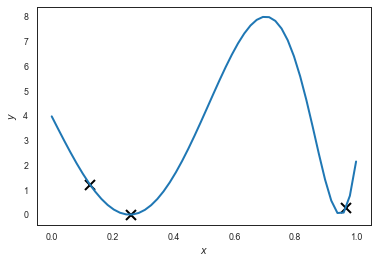

In [3]:
def f(x):
    return 4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

np.random.seed(123456) # For reproducibility
n_init = 3
X = np.random.rand(n_init) # In 1D you don't have to use LHS
Y = f(X)
plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
x = np.linspace(0, 1)
plt.plot(x, f(x), linewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$');

Just like in the previous hands-on activity, assume that we have made some observations and that we have used them to do Gaussian process regression resulting in the point-predictive distribution:
$$
p(y|\mathbf{x},\mathcal{D}_{n}) = \mathcal{N}\left(y|m_{n}(\mathbf{x}), \sigma^2_{n}(\mathbf{x})\right),
$$
where $m_{n}(\mathbf{x})$ and $\sigma^2_{n}(\mathbf{x})$ are the predictive mean and variance respectively.
Here is the code for this:

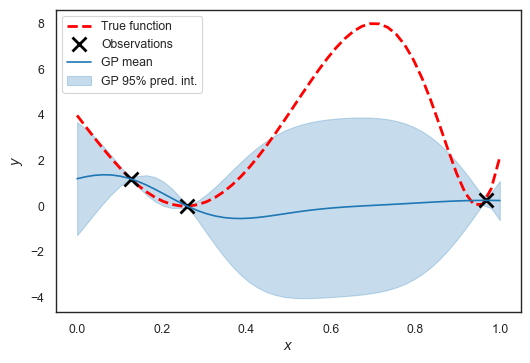

In [4]:
import GPy
# The kernel we use
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
# Assuming that we know there is no measurement noise:
gpr.likelihood.variance.constrain_fixed(1e-16)
# You can evaluate the predictive distribution anywhere:
m, sigma2 = gpr.predict(x[:, None])
# And you can visualize the results as follows
# Standard deviation
sigma = np.sqrt(sigma2)
# Lower quantile
l = m - 1.96 * sigma
u = m + 1.96 * sigma
fig, ax = plt.subplots(dpi=100)
plt.plot(x, f(x), 'r--', linewidth=2, label='True function')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='Observations')
ax.plot(x, m, label='GP mean')
ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25,
                label='GP 95% pred. int.')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

The expected improvement is a bit more involved, but it serves as a template for deriving more general information acquisition functions.
Here is how you think.
Consider a hypothetical experiment at $\mathbf{x}$ and assume that you observed $y$.
How much improvement is that compared to your currently best observed point $y_n^*$.
It is:
$$
I_n(\mathbf{x}, y) =
\begin{cases}
0,&\;\text{if}\;y \le y_n^*,\\
y - y_n^*,&\;\text{otherwise}.
\end{cases}
$$
But you don't know what $y$ is. What do you do now?
Well, the only legitimate thing to do is to take the expectation over what you expected $y$ to be given what you know at that moint.
So it is:
$$
\begin{align}
\operatorname{EI}_n(\mathbf{x}) &=& 
\int_{-\infty}^\infty I_n(\mathbf{x}, y)p(y|\mathbf{x}, \mathcal{D}_n)dy\\
&=& \int_{-\infty}^{y_n^*}0\cdot p(y|\mathbf{x}, \mathcal{D}_n)dy
+ \int_{y_n^*}^{\infty}(y - y_n^*)\cdot p(y|\mathbf{x}, \mathcal{D}_n)dy.
\end{align}
$$
You can work this out analytically.
You will get:
$$
\operatorname{EI}_n(\mathbf{x}) = \frac{m_n(\mathbf{x}) - y_n^*}{\sigma_n(\mathbf{x})}\Phi\left(\frac{m_n(\mathbf{x}) - y_n^*}{\sigma_n(\mathbf{x})}\right)
+ \phi\left(\frac{m_n(\mathbf{x}) - y_n^*}{\sigma_n(\mathbf{x})}\right).
$$

(0, 1)

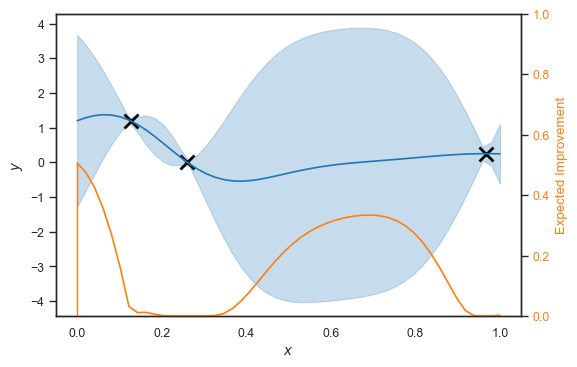

In [6]:
def ei(m, sigma, ymax, psi=0.):
    u = (m - ymax) / sigma
    ei = sigma * (u * st.norm.cdf(u) + st.norm.pdf(u))
    ei[sigma <= 0.] = 0.
    return ei

af_values = ei(m, sigma, Y.max())
idx = np.argmax(af_values)
af_max = af_values[idx]
next_x = x[idx]

fig, ax = plt.subplots(dpi=100)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(x, m)
ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
ax2 = ax.twinx()
ax2.plot(x, af_values, color=sns.color_palette()[1])
plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
ax2.set_ylabel('Expected Improvement', color=sns.color_palette()[1])
ax2.plot(next_x * np.ones(100), np.linspace(0, af_max, 100), color=sns.color_palette()[1],
         linewidth=1)
ax2.set_ylim(0, 1)

## Bayesian global optimization with the expected improvement

Let's now run the Bayesian global optimization algorithm using the expected improvement as the information acquisition function.
Here is the generic code from the previous hands-on activity:

In [7]:
def maximize(f, gpr, X_design, alpha, psi=0., max_it=6):
    """
    Optimize f using a limited number of evaluations.
    
    :param f:        The function to optimize.
    :param gpr:      A Gaussian process model to use for representing our state of knowldege.
    :param X_design: The set of candidate points for identifying the maximum.
    :param alpha:    The acquisition function.
    :param psi:      The parameter value for the acquisition function (not used for EI).
    :param max_it:   The maximum number of iterations.
    """
    af_all = []
    for count in range(max_it):
        m, sigma2 = gpr.predict(X_design)
        sigma = np.sqrt(sigma2)
        l = m - 1.96 * sigma
        u = m + 1.96 * sigma
        af_values = alpha(m, sigma, gpr.Y.max(), psi=psi)
        i = np.argmax(af_values)
        X = np.vstack([gpr.X, X_design[i:(i+1), :]])
        y = np.vstack([gpr.Y, [f(X_design[i, :])]])
        gpr.set_XY(X, y)
        # Uncomment the following to optimize the hyper-parameters
        # gpr.optimize()
        af_all.append(af_values[i])
        fig, ax = plt.subplots(dpi=100)
        ax.plot(gpr.X, gpr.Y, 'kx', markersize=10, markeredgewidth=2)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.plot(x, m)
        ax.fill_between(X_design.flatten(), l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
        ax2 = ax.twinx()
        ax2.plot(X_design, af_values, color=sns.color_palette()[1])
        plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
        ax2.set_ylabel('acquisition function', color=sns.color_palette()[1])
        ax2.plot(X_design[i, :] * np.ones(100), np.linspace(0, af_values[i], 100), color=sns.color_palette()[1],
                 linewidth=1)
    return af_all

And here is how we can use the code with the probability of improvement:

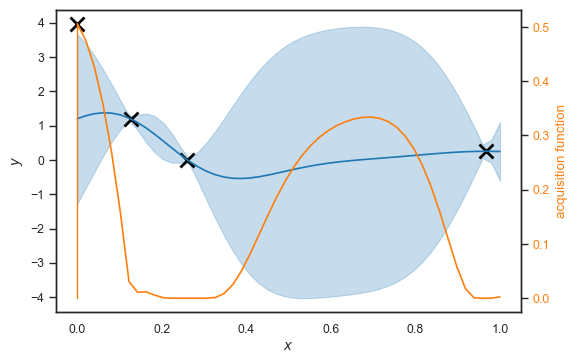

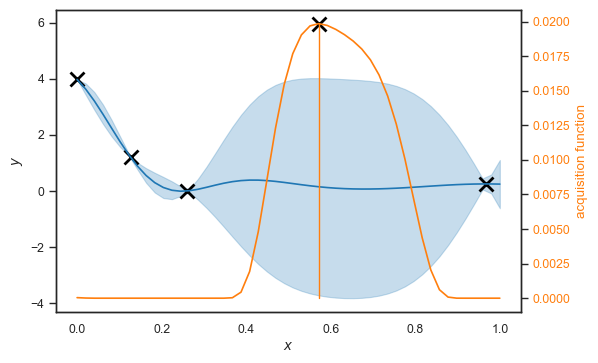

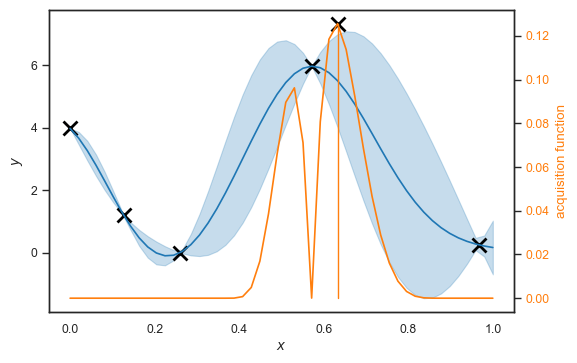

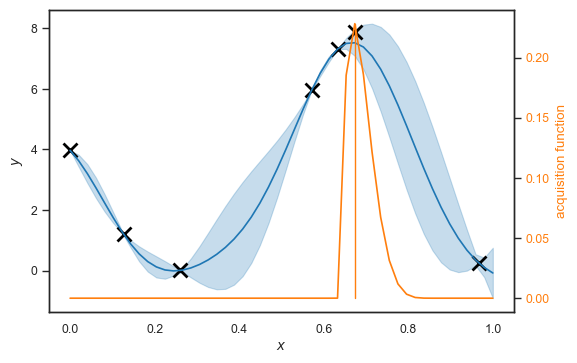

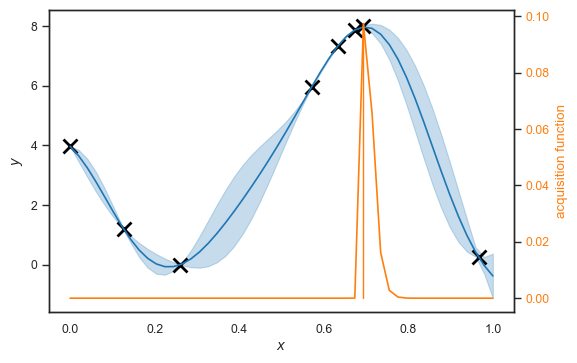

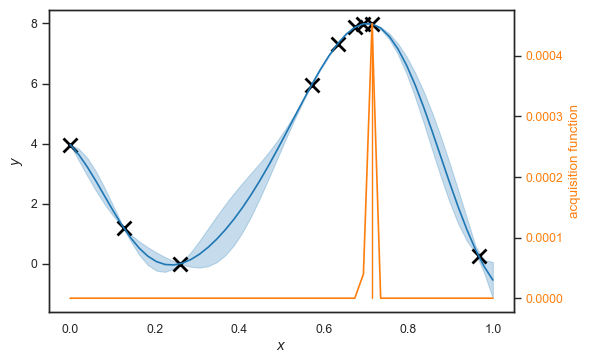

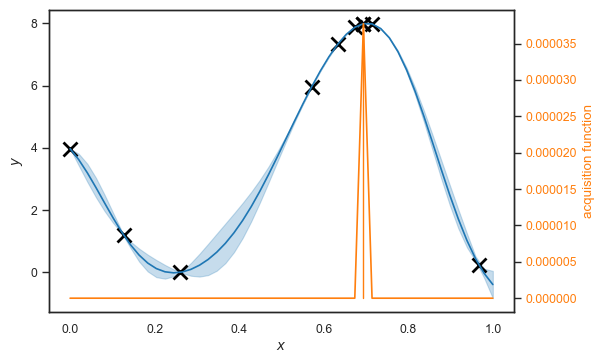

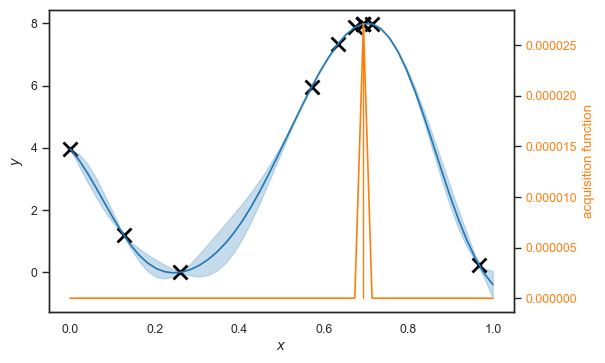

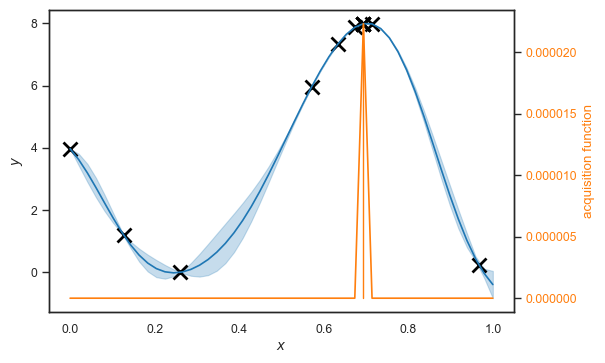

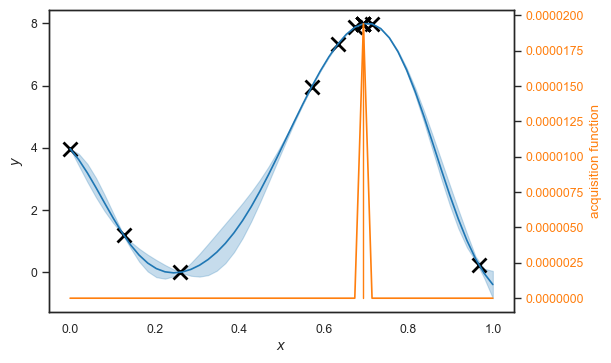

In [8]:
# Prepare the initial statistical model
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
gpr.likelihood.variance.constrain_fixed(1e-16)

# Run the algorithm
af_all = maximize(f, gpr, x[:, None], alpha=ei, max_it=10)

### Questions

+ Rerun the main algorithm for EI by optimizing the hyper-parameters. Hint: Go through the code of ``maximize``.